In [1]:
!pip install -q transformers datasets evaluate accelerate pipeline bitsandbytes torchdata peft loralib bert_score rouge_score huggingface_hub

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 22.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.9 MB/s eta 0:00:00:00:

In [2]:
import os
import torch
from datasets import load_dataset
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainingArguments,
)

2025-05-23 10:53:11.924228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747997592.109934      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747997592.165049      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import evaluate
import pandas as pd
import numpy as np
import json
import random
import seaborn as sns

In [4]:
dataset = load_dataset("knkarthick/dialogsum")

README.md:   0%|          | 0.00/4.65k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

validation.csv:   0%|          | 0.00/442k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [5]:
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

In [6]:
model_name = "t5-small"
max_input_length = 512
max_output_length = 150

tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [7]:
def preprocess_function(examples):
    inputs = ["dialogue: " + conversation for conversation in examples["dialogue"]]
    targets = examples["summary"]
    
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_output_length, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [8]:
train_dataset = train_dataset.map(preprocess_function, batched=True)
eval_dataset = eval_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [9]:
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
eval_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [11]:
import os
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
os.environ['WANDB_DISABLED'] = 'true'

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=500,
    save_steps=500,
    logging_steps=100,
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),  
    learning_rate=5e-5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_35/2625964742.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [12]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss
500,1.643300,1.479014
1000,1.549100,1.404679
1500,1.512200,1.384367
2000,1.453300,1.366038
2500,1.475800,1.342413
3000,1.437500,1.325644
3500,1.414400,1.320297
4000,1.427300,1.315129
4500,1.397700,1.306838
5000,1.380600,1.299028


TrainOutput(global_step=6230, training_loss=1.4685134330492342, metrics={'train_runtime': 613.2714, 'train_samples_per_second': 40.635, 'train_steps_per_second': 10.159, 'total_flos': 2176811100930048.0, 'train_loss': 1.4685134330492342, 'epoch': 2.0})

In [13]:
model.save_pretrained("./finetuned_model")
tokenizer.save_pretrained("./finetuned_model")

('./finetuned_model/tokenizer_config.json',
 './finetuned_model/special_tokens_map.json',
 './finetuned_model/spiece.model',
 './finetuned_model/added_tokens.json')

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
def generate_summary(conversation):
    input_text = "dialogue: " + conversation
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=max_input_length, truncation=True).to(device)
    summary_ids = model.generate(
        inputs,
        max_length=max_output_length,
        num_beams=4,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [16]:
example_conversation = (
    "User1: Hi, how are you? "
    "User2: I'm good, thanks! What about you? "
    "User1: I'm fine too. "
    "User2: Great to hear that."
)

print("Generated Summary:")
print(generate_summary(example_conversation))

Generated Summary:
User2 tells User1 he's good.


In [17]:
def get_model_evaluations(summaries):
  llm = [s['T5 Zero Shot'] for s in summaries]
  human = [s['human'] for s in summaries]

  rouge = evaluate.load('rouge')
  r = rouge.compute(
    predictions = llm,
    references = human,
    use_aggregator=False,
    use_stemmer=True,
    rouge_types =  ['rouge1','rouge2','rougeL']
   )

  bert = evaluate.load("bertscore")
  b = bert.compute(
      predictions = llm,
      references = human,
      lang='en'
  )['f1']

  r.update({'bert':b})

  return pd.DataFrame(r)

In [39]:
def plot_evaluation_metrics(scores_base, scores_tuned , scores_large_base , scores_large_tuned):
    scores_base['model'] = 'base'
    scores_tuned['model'] = 'tuned_small'
    # scores_large_base['model'] = 'base_large'
    # scores_large_tuned['model'] = 'tuned_large'
    
    df = pd.concat([scores_base,scores_tuned])
                    # ,scores_large_base , scores_large_tuned])
    df_long = pd.melt(df, id_vars=['model'],var_name='metric',value_name='score')
    
    plt.figure(figsize=(10,6))
    plot = sns.boxplot(x="metric", y="score",hue="model",data=df_long)
    plot.set(title = "Evaluation Metrics: Base model vs Fine Tuned Model's Comparsison")

In [19]:
def get_prompt(dialogue):
    prompt = "Summarize the following conversation:\n\n"
    prompt += f"{dialogue}"
    prompt += "\n\n Summary:"
    return prompt

In [20]:
def generate_summaries(conversation , model , tokenizer):
    input_text = "dialogue: " + conversation
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=max_input_length, truncation=True).to(device)
    summary_ids = model.generate(
        inputs.to(device),
        max_length=max_output_length,
        num_beams=4,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [29]:
from tqdm import tqdm
def generate_responses(data, model, tokenizer, indexes):
    summaries=[]
    for idx in tqdm(range(indexes)):
        dialogue = data['dialogue'][idx]
        human_summary = data['summary'][idx]
        prompt = "dialogue: " + dialogue
        llm_summary = generate_summaries(prompt, model, tokenizer)
        summary = {'index':idx,'human':human_summary,'T5 Zero Shot':llm_summary}
        summaries.append(summary)
        
    return summaries

In [30]:
dataset_test = dataset['test'].map(preprocess_function, batched=True)
dataset_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [32]:
summaries = generate_responses(dataset_test , model , tokenizer, 200)

100%|██████████| 200/200 [02:22<00:00,  1.40it/s]


In [35]:
eval_df_tuned = get_model_evaluations(summaries)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
untuned_model = T5ForConditionalGeneration.from_pretrained(model_name)

In [38]:
summaries_untuned = generate_responses(dataset_test , untuned_model.to(device) , tokenizer, 200)

100%|██████████| 200/200 [02:58<00:00,  1.12it/s]


In [40]:
eval_df_untuned = get_model_evaluations(summaries_untuned)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


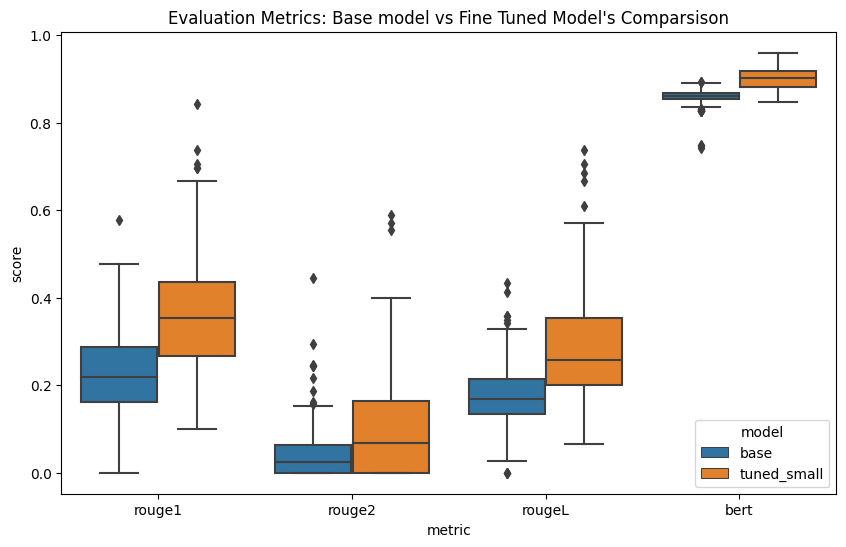

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
plot_evaluation_metrics(eval_df_untuned,eval_df_tuned,0,0)